# Generate Datasets
Scripts required for generating the toy datasets used in experiments. 
These datasets include
- ball dataset :- overlapping positive and negative balls
- ring dataset :- positive ball surrounded by a ring of negative points
- half_ring dataset :- positive ball surrounded by half ring of negative points
- inverted_half_ring dataset :- negative ball surrounded by half ring of positive points

In [2]:
import torch

SEED = 2703

def reset_seed():
    torch.manual_seed(SEED)

def shuffle(X, Y):
    reset_seed()
    data = torch.cat((Y, X), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, 1:]
    Y = data[:, 0]
    return X, Y

In [5]:
def generate_uniform_point_cloud(n, disc_out_rad, disc_in_rad=0, half_disc=False):
    # Produce point cloud centred around the origin, uniformly sampled from ball of radius 1
    assert disc_in_rad>=0, "Error: Disc Radii must be positive"
    assert disc_out_rad>disc_in_rad, "Error: Disc outer radius must be bigger than inner radius"
    
    radii = torch.rand(size = (n,1)) # [0,1]
    # Scale the radii to be the disc width
    radii = torch.sqrt((disc_out_rad**2-disc_in_rad**2)*radii + disc_in_rad**2)
    
    if half_disc:
        #Cloud sits along 180 degree arc
        max_angle = torch.pi
    else:
        # Cloud forms a full 360 degree shell
        max_angle = 2*torch.pi

    angles = max_angle * torch.rand(size = (n,1)) # [0, 2*pi]
    c = torch.cos(angles)
    s = torch.sin(angles)
    
    data= radii*torch.cat([c, s], dim=1)
    return data

def generate_dataset(N, ball_rad=2, disc_out_rad=5, disc_in_rad=3, half_disc=False):
    n_pos = int(N/2)
    n_neg = N-n_pos

    pos_data = generate_uniform_point_cloud(n_pos, ball_rad)
    neg_data = generate_uniform_point_cloud(n_neg, disc_out_rad, disc_in_rad, half_disc)
    X = torch.cat([pos_data, neg_data], dim=0)

    y_pos = torch.ones(n_pos).unsqueeze(1)
    y_neg = -torch.ones(n_pos).unsqueeze(1)
    Y = torch.cat([y_pos, y_neg], dim=0)

    X,Y = shuffle(X, Y)
    return X, Y


In [6]:
import pandas as pd

def save_dataset(X, Y, dataset_name):
    Z = torch.cat((X,Y.unsqueeze(1)), 1).numpy()
    df = pd.DataFrame(Z)

    df.to_csv(f'{dataset_name}.csv', index=False)

# Generate Ball Dataset
Slightly overlapping positive and negative balls

In [ ]:
import numpy as np 

def gen_custom_normal_data(N, x_dim, pos_mean, pos_std, neg_mean, neg_std, pos_noise_frac=0.01, neg_noise_frac=0.01):
    reset_seed()
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, x_dim))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, x_dim))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.from_numpy(np.random.choice([1, -1], len(posX), p=[1-pos_noise_frac, pos_noise_frac])),
                                   torch.from_numpy(np.random.choice([-1, 1], len(posX), p=[1-neg_noise_frac, neg_noise_frac]))),
                                  0), 1)
    
    X, Y = shuffle(X, Y)
    return X, Y

In [46]:
import numpy as np

x_dim = 2
N = 5000

blobs_dist = 5
#blobs_std = 0.25
blobs_std = 1.5
pos_noise_frac = 0.0
neg_noise_frac = 0.0

X, Y = gen_custom_normal_data(N, x_dim,
                              np.array([blobs_dist/2+10, 0]),
                              np.array([blobs_std, 0.2]),
                              np.array([-blobs_dist/2+10, 0]),
                              np.array([blobs_std, 0.2]),
                              pos_noise_frac=pos_noise_frac,
                              neg_noise_frac=neg_noise_frac)

In [47]:
dataset_name = f'normal_data_dist_2_std_0_25'.replace('.', '_') 
save_dataset(X, Y, dataset_name)

# Generate Ball Ring Dataset
Generate dataset with positive ball surrounded by negative ring

In [48]:
N = 5000

ball_rad = 2
disc_in_rad = 3
disc_out_rad = 5
half_disc = False

X,Y = generate_dataset(N, ball_rad, disc_out_rad, disc_in_rad, half_disc)

In [49]:

dataset_name = f'ball_ring_dataset_ball_rad_{ball_rad}_in_rad_{disc_in_rad}_out_rad_{disc_out_rad}'.replace('.', '_') 
save_dataset(X, Y, dataset_name)

# Generate Ball Half-Ring Dataset
Generate dataset with positive ball with an adjacent half ring

In [50]:
N = 5000

ball_rad = 2
disc_in_rad = 3
disc_out_rad = 5
half_disc = True

X,Y = generate_dataset(N, ball_rad, disc_out_rad, disc_in_rad, half_disc)

In [51]:
dataset_name = f'ball_half_ring_dataset_ball_rad_{ball_rad}_in_rad_{disc_in_rad}_out_rad_{disc_out_rad}'.replace('.', '_') 
save_dataset(X, Y, dataset_name)

# Generate Inverted Half-Ring Dataset

In [25]:
def generate_inverted_dataset(N, ball_rad=2, disc_out_rad=5, disc_in_rad=3, half_disc=False):
    """Same ball and ring dataset, but now it's a positive outer shell and a negative core"""
    n_pos = int(N/2)
    n_neg = N-n_pos

    neg_data = generate_uniform_point_cloud(n_pos, ball_rad)
    pos_data = generate_uniform_point_cloud(n_neg, disc_out_rad, disc_in_rad, half_disc)
    X = torch.cat([pos_data, neg_data], dim=0)

    y_pos = torch.ones(n_pos).unsqueeze(1)
    y_neg = -torch.ones(n_pos).unsqueeze(1)
    Y = torch.cat([y_pos, y_neg], dim=0)

    X,Y = shuffle(X, Y)
    return X, Y

In [52]:
N = 5000

ball_rad = 2
disc_in_rad = 3
disc_out_rad = 5
half_disc = True

X,Y = generate_inverted_dataset(N, ball_rad, disc_out_rad, disc_in_rad, half_disc)

In [53]:
dataset_name = f'ball_half_ring_inverted_dataset_ball_rad_{ball_rad}_in_rad_{disc_in_rad}_out_rad_{disc_out_rad}'.replace('.', '_') 
save_dataset(X, Y, dataset_name)

# Twin Moons Dataset

In [7]:
from sklearn.datasets import make_moons

N = 5000

#X, Y = make_moons(n_samples=N, noise=0.2, random_state=SEED)
X, Y = make_moons(n_samples=N, noise=0.075, random_state=SEED)

X = torch.from_numpy(X)
Y = torch.where(torch.from_numpy(Y)==0, -1, 1)

In [55]:
dataset_name = f'twin_moons'.replace('.', '_') 
save_dataset(X, Y, dataset_name)

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
def visualize_data2D(X, y):
    """Visualise 2D Dataset"""
    assert X.size(1) == 2
    if not X.size(1) == 2:
        return
    
    Xpos = X[y == 1]
    Xneg = X[y == -1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='red')
    plt.show()

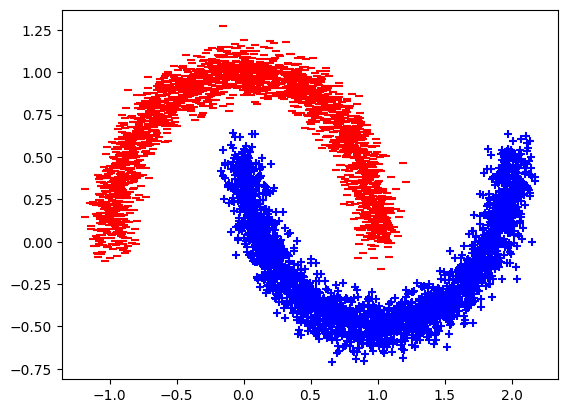

In [9]:
visualize_data2D(X, Y)